<a href="https://colab.research.google.com/github/Jiwei-Cao/Market-Time-Series-Forecasting-Pipeline/blob/main/Market_Time_Series_Forecasting_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install yfinance scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [55]:
SYMBOL = "BTC-USD"
LOOKBACK = 7
TRAIN_SPLIT = 0.95
BATCH_SIZE = 16
HIDDEN_SIZE = 16
NUM_LAYERS = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

In [56]:
print("Fetching data from Yahoo Finance...")

raw_df = yf.download(SYMBOL, period="400d", interval="1d")

raw_df = raw_df.reset_index()

data = raw_df[["Date", "Close"]].copy()

data.rename(columns={"Date": "timeOpen", "Close": "close"}, inplace=True)

data.head()

/tmp/ipython-input-1341395777.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_df = yf.download(SYMBOL, period="400d", interval="1d")
[*********************100%***********************]  1 of 1 completed

Fetching data from Yahoo Finance...


Price,timeOpen,close
Ticker,,BTC-USD
0,2024-10-22,67361.406250
1,2024-10-23,66432.195312
2,2024-10-24,68161.054688
3,2024-10-25,66642.414062
4,2024-10-26,67014.695312


In [57]:
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df.set_index("timeOpen", inplace=True)

  for i in range(1, n_steps + 1):
    df[f"Close(t-{i})"] = df["close"].shift(i)

  df.dropna(inplace=True)

  return df

In [58]:
shifted_df = prepare_dataframe_for_lstm(data, LOOKBACK)
print(f"Shifted DataFrame head: {shifted_df.head()}")

shifted_np = shifted_df.to_numpy()

Shifted DataFrame head: Price              close    Close(t-1)    Close(t-2)    Close(t-3)  \
Ticker           BTC-USD                                             
timeOpen                                                             
2024-10-29  72720.492188  69907.757812  67929.296875  67014.695312   
2024-10-30  72339.539062  72720.492188  69907.757812  67929.296875   
2024-10-31  70215.187500  72339.539062  72720.492188  69907.757812   
2024-11-01  69482.468750  70215.187500  72339.539062  72720.492188   
2024-11-02  69289.273438  69482.468750  70215.187500  72339.539062   

Price         Close(t-4)    Close(t-5)    Close(t-6)    Close(t-7)  
Ticker                                                              
timeOpen                                                            
2024-10-29  66642.414062  68161.054688  66432.195312  67361.406250  
2024-10-30  67014.695312  66642.414062  68161.054688  66432.195312  
2024-10-31  67929.296875  67014.695312  66642.414062  68161.054688  
2

In [59]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_np = scaler.fit_transform(shifted_np)

In [60]:
X = shifted_np[:, 1:]
y = shifted_np[:, 0]

# reverse time order inside each window so model sees oldest to newest
X = dc(np.flip(X, axis=1))

split_index = int(len(X) * TRAIN_SPLIT)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

test_dates = shifted_df.index[split_index:]

print(f"Shapes before reshape:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes before reshape: (373, 7) (20, 7) (373,) (20,)


In [61]:
X_train = X_train.reshape((-1, LOOKBACK, 1))
X_test = X_test.reshape((-1, LOOKBACK, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print(f"Shapes after reshape:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes after reshape: (373, 7, 1) (20, 7, 1) (373, 1) (20, 1)


In [62]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [63]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True
    )

    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out

In [65]:
model = LSTMModel(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
model

LSTMModel(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [66]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_one_epoch(epoch):
  model.train()
  running_loss = 0.0

  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  print(f"Epoch {epoch+1:3d} | Train loss: {avg_loss:.6f}")

def validate_one_epoch():
  model.eval()
  running_loss = 0.0

  with torch.inference_mode():
    for x_batch, y_batch in test_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      output = model(x_batch)
      loss = loss_fn(output, y_batch)
      running_loss += loss.item()

  avg_loss = running_loss / len(test_loader)
  print(f"Test loss: {avg_loss:.6f}")

  return avg_loss

In [67]:
for epoch in range(NUM_EPOCHS):
  train_one_epoch(epoch)
  validate_one_epoch()

Epoch   1 | Train loss: 0.252835
Test loss: 0.073048
Epoch   2 | Train loss: 0.157592
Test loss: 0.117735
Epoch   3 | Train loss: 0.102918
Test loss: 0.114606
Epoch   4 | Train loss: 0.059443
Test loss: 0.060681
Epoch   5 | Train loss: 0.028275
Test loss: 0.024400
Epoch   6 | Train loss: 0.021161
Test loss: 0.016607
Epoch   7 | Train loss: 0.017730
Test loss: 0.019877
Epoch   8 | Train loss: 0.016236
Test loss: 0.021189
Epoch   9 | Train loss: 0.015596
Test loss: 0.018678
Epoch  10 | Train loss: 0.015245
Test loss: 0.021983
Epoch  11 | Train loss: 0.014786
Test loss: 0.021241
Epoch  12 | Train loss: 0.014422
Test loss: 0.027169
Epoch  13 | Train loss: 0.014143
Test loss: 0.021823
Epoch  14 | Train loss: 0.013885
Test loss: 0.020197
Epoch  15 | Train loss: 0.013142
Test loss: 0.021343
Epoch  16 | Train loss: 0.013002
Test loss: 0.017984
Epoch  17 | Train loss: 0.012887
Test loss: 0.020437
Epoch  18 | Train loss: 0.012565
Test loss: 0.016187
Epoch  19 | Train loss: 0.012535
Test loss: 0.

In [68]:
model.eval()
with torch.inference_mode():
  preds_scaled = model(X_test.to(device)).cpu().numpy().flatten()

# inverse scale predictions
dummies = np.zeros((X_test.shape[0], LOOKBACK + 1))
dummies[:, 0] = preds_scaled
dummies = scaler.inverse_transform(dummies)
preds = dc(dummies[:, 0])

# inverse scale actuals
dummies = np.zeros((X_test.shape[0], LOOKBACK + 1))
dummies[:, 0] = y_test.numpy().flatten()
dummies = scaler.inverse_transform(dummies)
actuals = dc(dummies[:, 0])

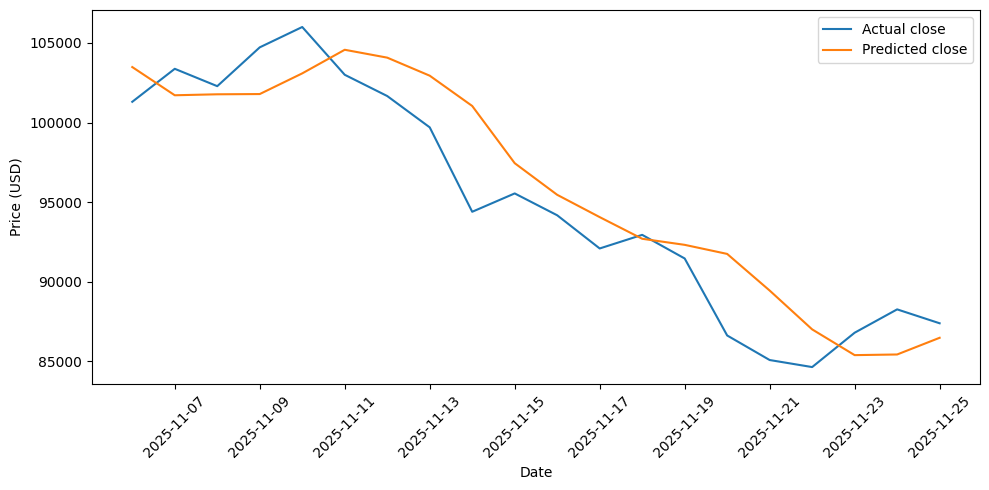

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(test_dates, actuals, label="Actual close")
plt.plot(test_dates, preds, label="Predicted close")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()